<a href="https://colab.research.google.com/github/easykvasha/arbitrage-opportunity/blob/main/Kadygrov_crypto_arbitrage_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Введите кол-во криптовалют: 
6
Введите краткие названия криптовалют: 
ETH
ETC
LTC
EOS
TRX
BCH

Запрашиваем курсы, запускаем алгоритм Беллмана-Форда, ищем арбитражную возможность...

Нет арбитражной возможности .


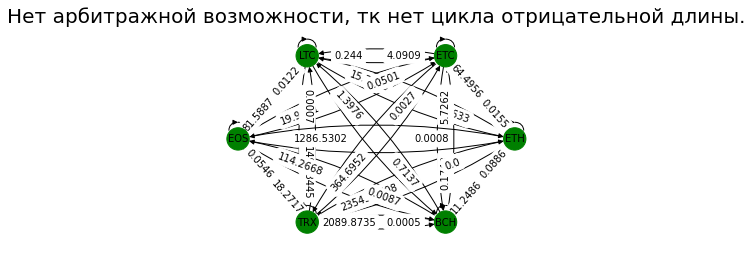

<Figure size 5000x5000 with 0 Axes>

In [2]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import requests
import json

AUTH = ""

def load_price(a,b):
    """
    Получилось подключиться к бесплатной API платформы cryptocompare.
    Она подключается к binance и выкачивает котировки. Затем записывает их в файл pairs_list.json.
    """
    url = (
        "https://min-api.cryptocompare.com/data/price?fsym="+ a + "&tsyms=" + b + "&api_key=" + AUTH

    )

    r = requests.get(url)
    with open("pairs_list.json", "w") as f:
      json.dump(r.json(), f)


class Graph:

    def __init__(self, num, labels):
        self.nodes = num
        self.edges = []
        self.tickers = labels
        self.currency_matrix = np.zeros((num, num))

    def define_edges(self, s, e, v):
        """
          s=start, e=end, v=value
        """
        self.edges.append([s, e, v])

    def build_graph(self):
        """
          Строим матрицу из валют и курсов, к тому же добавляем ребра к графу
        """
        for i in range(self.nodes):
            for j in range(self.nodes):
                if i == j:
                    # Диагональ всегда 1
                    data = 1
                else:
                    # Формат вывода курсов -->  "BTC/ETH="
                    aux = str(tickers[i] +'/'+ tickers[j] + '=')

                    # Подтягиваем все курсы по парам валют
                    load_price(tickers[i],tickers[j])
                    with open("pairs_list.json", "r") as f:
                      pairs = json.load(f)
                    for val in pairs.values():
                      data = round(val*0.999,8)

                    #print(aux, data)

                # Сохраняем матрицу и ребра
                self.currency_matrix[i][j] = data
                self.define_edges(i, j, round(-math.log(data, 10), 5))

    def Bellman_Ford(self):

        # 1° Создаем граф
        print('\nЗапрашиваем курсы, запускаем алгоритм Беллмана-Форда, ищем арбитражную возможность...')
        self.build_graph()

        # 2° Вводим расстояния между вершинами
        dist = [float("Inf")] * self.nodes
        path = [float("Inf")] * self.nodes
        dist[0] = 0
        path[0] = 0
        profit = 1

        # 3° Релаксация ребер и проверка на кратчайший путь с помощью вложенных циклов
        for i in range(self.nodes - 1):
            for s, e, v in self.edges:
                if dist[s] != float("Inf") and dist[s] + v < dist[e]:
                    dist[e] = dist[s] + v
                    path[e] = s

        # 4° Поиск отрицательных циклов
        Neg_cycles = self.Negative_Cycle(dist, path)

        # 5° Вывод результата
        if not Neg_cycles:
            print("\nНет арбитражной возможности .")
            self.Display_Graph(path, 0, 0)

        else:

            for neg_cycle in Neg_cycles:
                print("\nАрбитражная возможность найдена:")
                print('  ' + " --> ".join([self.tickers[i]
                                           for i in neg_cycle[::-1]]))
                prec = neg_cycle[-1]
                for i in neg_cycle[-2::-1]:
                    profit *= self.currency_matrix[prec][i]
                    prec = i
                profit = round(profit, 4)
                print("  Profit: ", profit)
                self.Display_Graph(neg_cycle, profit, 1)

    def Negative_Cycle(self, dist, path):
        Neg_cycles = []
        flag = False
        for s, e, v in self.edges:
            # Проверка расстояния после схождения алгоритма
            if dist[s] + v < dist[e] and dist[s] != float("Inf"):
                neg_cycle = [e, s]
                aux = s  # auxiliary variable

                # Идем в обратную сторону по изначальному пути
                while path[aux] not in neg_cycle:
                    neg_cycle.append(path[aux])
                    aux = path[aux]
                neg_cycle.append(path[aux])

                # Выбор подходящего цикла
                if neg_cycle[0] == neg_cycle[-1] and len(neg_cycle) > 3:
                    Neg_cycles.append(neg_cycle)
                    flag = True

        if(flag):
            return Neg_cycles
        else:
            return False

    def Display_Graph(self, path, profit, flag):
        """
        Визуализация полученных результатов
        """

        path_edges = []
        graph_view = nx.MultiDiGraph()

        for s, e, v in self.edges:
            graph_view.add_edge(s, e, weight=round(10**(-v), 4))

        pos = nx.circular_layout(graph_view)

        if flag == 0:

            plt.title('Нет арбитражной возможности, тк нет цикла отрицательной длины.', fontsize=20)

        else:

            # Подсвечивание цикла отрицательной длины
            for i in range(len(path)-1):
                path_edges.append((path[i+1], path[i]))

            plt.text(-1.3, -1.3, "Нашли цикл отрицательной длины: \n\n" + '  ' + " --> ".join([self.tickers[i] for i in path[::-1]])
                     + "\n\nProfit: " + str(profit),
                     bbox=dict(boxstyle="square", facecolor="white"), size=12.5)
            plt.title('Арбитражная возможность', fontsize=20)

        edge_labels = dict([((u, v,), d['weight'])
                            for u, v, d in graph_view.edges(data=True)])
        edge_colors = [
            'black' if not edge in path_edges else 'red' for edge in graph_view.edges()]
        node_colors = ['green' for path in graph_view.nodes()]

        labels = {}
        for i in range(len(self.tickers)):
            labels[i] = self.tickers[i]

        nx.draw_networkx_edge_labels(
            graph_view, pos, label_pos=0.3, edge_labels=edge_labels)
        nx.draw(graph_view, pos, node_size=500, node_color=node_colors, edge_color=edge_colors, with_labels=False,
                connectionstyle='arc3, rad = 0.1')
        nx.draw_networkx_labels(graph_view, pos, labels,
                                font_size=10, font_color='black')

        plt.figure(figsize=(100, 100), dpi=50)
        plt.show()


if __name__ == "__main__":

    tickers = []

    print('Введите кол-во криптовалют: ')
    numV = int(input())

    print('Введите краткие названия криптовалют: ')

    for x in range(numV):
        tickers.append(str(input()))

    g = Graph(numV, tickers).Bellman_Ford()

Итоговая прибыль: 106.24014093247146


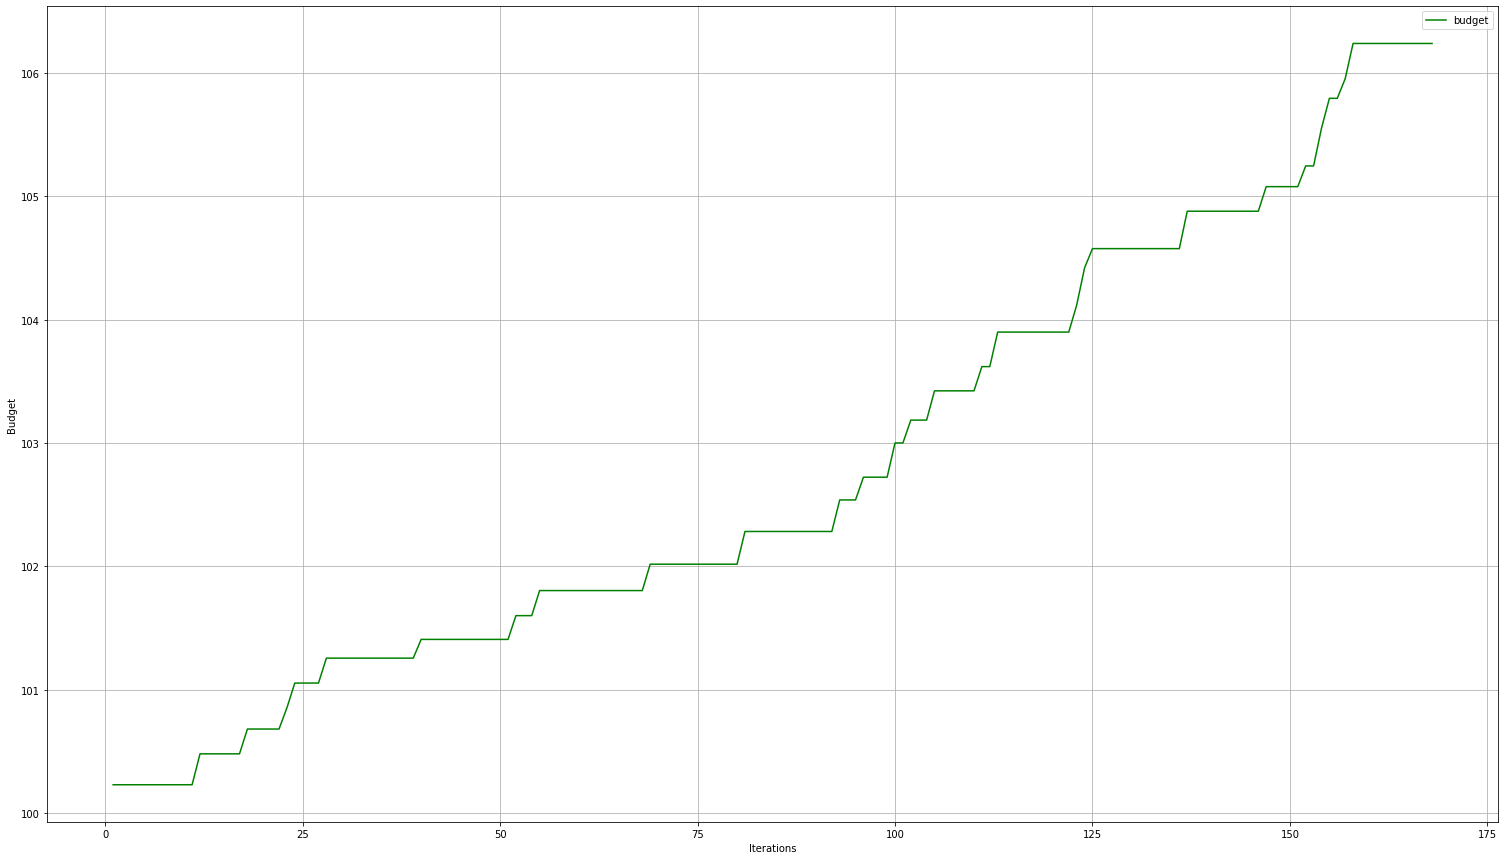

In [26]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


iter = [x for x in range(1, 169)]
prof = np.random.randint(10015, 10030, size = 28)
prof = prof / 10000
#print(prof)
prof = np.pad(prof, (0, 140), 'constant', constant_values = 1)
#print(prof)
np.random.shuffle(prof)
#print(prof)

money = 100
money_list = []
for i in range(len(prof)):
  money = money * prof[i]
  money_list.append(money)
#print(money_list)
print('Итоговая прибыль:', max(money_list))

plt.figure(figsize=(26, 15))
plt.plot(iter, money_list, c='green', label='budget')
plt.ylabel('Budget')
plt.xlabel('Iterations')
plt.legend(loc='best')
plt.grid()
plt.show()